<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/mbp_aki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of AKI risk depending on BP during surgery
In this example, we will calculate the risk of acute kidney injury (AKI) depending on blood pressure during surgery, using the VitalDB open dataset.

## Required libraries and datasets

In [1]:
!pip install vitaldb
import vitaldb
import pandas as pd
import numpy as np

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # Load clinical data
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # Load track list
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # Load lab result

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


## Case Selection
- Let's use only 100 emergency surgical patients.

In [2]:
# inclusion / exclusion criteria
caseids = list(
    set(df_trks.loc[df_trks['tname'] == 'Solar8000/ART_MBP', 'caseid']) &
    set(df_cases.loc[df_cases['department'] == 'General surgery', 'caseid']) &
    set(df_cases.loc[df_cases['emop'] == 1, 'caseid'])
)
caseids = caseids[:100]
print('Total {} cases found'.format(len(caseids)))

Total 100 cases found


## Load and calculate data for each case
- First of all, calculate the preoperative and postoperative creatinine concentration for each case, and then calculate the possibility that AKI occurs.

- Secondly, obtain the ART_MBP data from vitaldb datasets. Then, calculate the proportion of surgeries that have a measured value lower than the threshold between 40-80 mmHg in all surgeries.

In [5]:
# Set blood pressure threshold
mbp_thresholds = np.arange(40, 80)
rows = []

# Save the final result
df = pd.DataFrame()
for caseid in caseids:
    print('loading {}...'.format(caseid), flush=True, end='')

    # Column ['anend'] : anesthesia end time
    aneend = df_cases[(df_cases['caseid'] == caseid)]['aneend'].values[0]

    # Last creatinine concentration before surgery
    preop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] < 0) & (df_labs['name'] == 'cr')].sort_values(by=['dt'], axis=0, ascending=False)['result'].values.flatten()
    if len(preop_cr) == 0:
        print('no preop cr')
        continue
    preop_cr = preop_cr[0]

    # Maximum creatinine concentration within 48 hours after surgery
    postop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] > aneend) &
        (df_labs['dt'] < aneend + 48 * 3600) & (df_labs['name'] == 'cr')]['result'].max(skipna=True)
    if not postop_cr or np.isnan(postop_cr):
        print('no postop cr')
        continue

    # KDIGO stage I
    aki = postop_cr > preop_cr * 1.5

    # Blood pressure during surgery
    mbps = vitaldb.load_case(caseid, 'ART_MBP').flatten()
    mbps = mbps[~np.isnan(mbps)]
    mbps = mbps[(mbps > 20) & (mbps < 150)]
    if len(mbps) < 10:
        print('no mbp')
        continue

    # Calculate the percentage that stays for the time as increasing the blood pressure by 1 unit.
    row = {'aki':aki}
    for mbp_threshold in mbp_thresholds:
        row['under{}'.format(mbp_threshold)] = np.nanmean(mbps < mbp_threshold) * 100

    # Append the result into row
    rows.append(row)

    print('{} -> {}, {}'.format(preop_cr, postop_cr, 'AKI' if aki else 'no AKI'))

df = pd.DataFrame(rows)
print('{} AKI {:.1f}%'.format(df['aki'].sum(), df['aki'].mean() * 100))

loading 6144...0.5 -> 0.57, no AKI
loading 2063...0.71 -> 1.26, AKI
loading 4112...no postop cr
loading 4115...1.07 -> 0.9, no AKI
loading 4116...0.63 -> 0.72, no AKI
loading 24...no preop cr
loading 29...0.78 -> 0.74, no AKI
loading 32...no postop cr
loading 4135...2.65 -> 2.3, no AKI
loading 4144...17.74 -> 15.82, no AKI
loading 6196...0.82 -> 1.0, no AKI
loading 4150...no postop cr
loading 4155...1.15 -> 2.19, AKI
loading 60...9.36 -> 7.95, no AKI
loading 2117...0.84 -> 0.89, no AKI
loading 4168...0.73 -> 0.62, no AKI
loading 2130...14.8 -> 9.02, no AKI
loading 83...8.13 -> 7.36, no AKI
loading 87...2.72 -> 2.35, no AKI
loading 2138...no postop cr
loading 2147...0.44 -> 0.52, no AKI
loading 4195...0.89 -> 0.96, no AKI
loading 2157...0.78 -> 0.74, no AKI
loading 4213...0.88 -> 0.66, no AKI
loading 6262...no preop cr
loading 124...0.63 -> 0.63, no AKI
loading 2174...5.42 -> 4.63, no AKI
loading 4225...no postop cr
loading 6273...no preop cr
loading 138...0.72 -> 0.65, no AKI
loading 6

## Calculate the odds ratio for AKI prediction depending on blood pressure threshold

- Let's calculate the odds ratio regarding how much each BP class increases the risk of AKI, using the above-measured values.

In [6]:
import statsmodels.api as sm

# Get odd ration using univariate logistic regression
df['intercept'] = 1
df['aki'] = df['aki'].astype(bool)
odd_ratios = []
for mbp_threshold in mbp_thresholds:
    c = 'under{}'.format(mbp_threshold)
    model = sm.Logit(df['aki'], df[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.278640
         Iterations 7
under40	b=0.329, exp(b)=1.390, pval=0.026
Optimization terminated successfully.
         Current function value: 0.276060
         Iterations 7
under41	b=0.311, exp(b)=1.365, pval=0.022
Optimization terminated successfully.
         Current function value: 0.275147
         Iterations 7
under42	b=0.285, exp(b)=1.329, pval=0.023
Optimization terminated successfully.
         Current function value: 0.269124
         Iterations 7
under43	b=0.271, exp(b)=1.312, pval=0.016
Optimization terminated successfully.
         Current function value: 0.263108
         Iterations 7
under44	b=0.247, exp(b)=1.280, pval=0.010
Optimization terminated successfully.
         Current function value: 0.260074
         Iterations 7
under45	b=0.212, exp(b)=1.236, pval=0.012
Optimization terminated successfully.
         Current function value: 0.257080
         Iterations 7
under46	b=0.181, exp(b)=1.199, pva

## Draw a graph
- You can find out that the odds ratio of AKI increases as the MBP stays below 60-65mmHg longer.


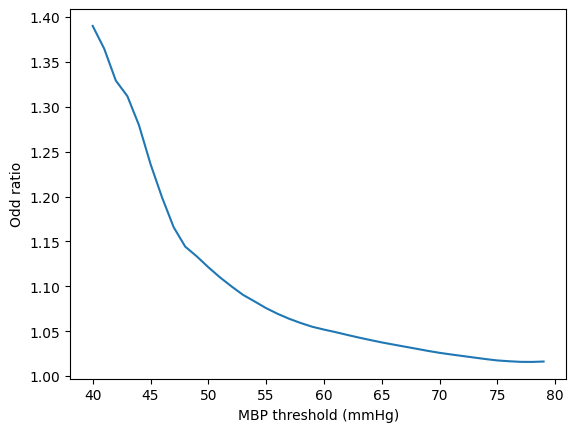

In [7]:
import matplotlib.pyplot as plt
plt.plot(mbp_thresholds, odd_ratios)
plt.xlabel('MBP threshold (mmHg)')
plt.ylabel('Odd ratio')
plt.show()